In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from collections import defaultdict

In [2]:
data_dir = "/Users/kanadb/Work/IIT-KGP Summer/cancer-research/datasets/TCGA-BRCA-CNV-tumor-Gene-Level"
file_pattern = "**/*.tsv"

output_dir = "processed_cnv_files"
os.makedirs(output_dir, exist_ok=True)

In [3]:
file_paths = glob.glob(os.path.join(data_dir, file_pattern), recursive=True)

In [4]:
all_cnv_counts = []
all_gene_freqs = []

In [5]:
# Track how many unique samples each gene is altered in
gene_to_samples = defaultdict(set)

In [6]:
# for file_path in file_paths:
#     try:
#         df = pd.read_csv(file_path, sep='\t')
#         df.columns = [col.strip() for col in df.columns]

#         # Convert column data type
#         df['start'] = pd.to_numeric(df['start'], errors='coerce')
#         df['end'] = pd.to_numeric(df['end'], errors='coerce')
#         df['copy_number'] = pd.to_numeric(df['copy_number'], errors='coerce')
#         df['min_copy_number'] = pd.to_numeric(df['min_copy_number'], errors='coerce')
#         df['max_copy_number'] = pd.to_numeric(df['max_copy_number'], errors='coerce')

#         # # Handle missing genomic positions
#         # df['start'] = df['start'].ffill().bfill()
#         # df['end'] = df['end'].ffill().bfill()

#         # Impute missing CN values with normal value 2
#         imputer = SimpleImputer(strategy='constant', fill_value=2)
#         # copy_cols = ['copy_number', 'min_copy_number', 'max_copy_number']
#         copy_cols = ['copy_number']
#         df[copy_cols] = imputer.fit_transform(df[copy_cols])

#         # Classify CNV type
#         def classify(cn):
#             if cn > 2:
#                 return "Amplified"
#             elif cn < 2:
#                 return "Deleted"
#             else:
#                 return "Normal"
                
#         df['CNV_Type'] = df['copy_number'].apply(classify)

#         # Compute CNV Magnitude
#         df['CNV_Magnitude'] = (df['copy_number'] - 2)

#         # Save lightweight version to disk
#         save_cols = ['gene_name', 'copy_number', 'CNV_Type', 'CNV_Magnitude']
#         sample_name = os.path.splitext(os.path.basename(file_path))[0]
#         df[save_cols].to_csv(os.path.join(output_dir, f"{sample_name}_cnv.csv"), index=False)
        
#         # Store per-gene CNV classification frequency
#         gene_freq = df.groupby(['gene_name', 'CNV_Type']).size().unstack(fill_value=0)
#         gene_freq['Total'] = gene_freq.sum(axis=1)
#         gene_freq['Amplification_Frequency'] = gene_freq.get('Amplified', 0) / gene_freq['Total']
#         gene_freq['Deletion_Frequency'] = gene_freq.get('Deleted', 0) / gene_freq['Total']
#         gene_freq.reset_index(inplace=True)
        
#         # Save per-sample frequency table
#         gene_freq['Sample'] = os.path.basename(file_path)
#         all_gene_freqs.append(gene_freq)

#         # # Store dataframe
#         # merged_dfs.append(df)

#         # Count CNV counts per sample
#         cnv_counts = df['CNV_Type'].value_counts().reindex(["Amplified", "Deleted", "Normal"], fill_value=0)
#         all_cnv_counts.append(cnv_counts)

#         # Histogram Plot
#         # plt.hist(df['copy_number'], color='gray', edgecolor='black')
#         # plt.xlabel('Copy Number')
#         # plt.ylabel('Frequency')
#         # plt.show()

#         # CNV Types Plot
#         # cnv_types = df['CNV_Type'].value_counts().sort_index()
#         # plt.bar(cnv_types.index, cnv_types.values, color=['blue', 'red', 'green'])
#         # plt.title('CNV Type Counts')
#         # plt.xlabel('CNV Type')
#         # plt.ylabel('Count')
#         # plt.show()

#     except Exception as e:
#         print(f"Error processing {file_path}: {e}")

In [7]:
# Process all files
for file_path in file_paths:
    try:
        # Load file
        df = pd.read_csv(file_path, sep='\t')
        df.columns = [col.strip() for col in df.columns]
        sample_name = os.path.splitext(os.path.basename(file_path))[0]

        # Convert columns to numeric
        for col in ['start', 'end', 'copy_number', 'min_copy_number', 'max_copy_number']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Impute missing copy_number with 2
        df[['copy_number']] = SimpleImputer(strategy='constant', fill_value=2).fit_transform(df[['copy_number']])

        # Classify CNV type
        def classify(cn): return "Amplified" if cn > 2 else "Deleted" if cn < 2 else "Normal"
        df['CNV_Type'] = df['copy_number'].apply(classify)

        # Filter only altered rows (Amplified or Deleted)
        altered_df = df[df['CNV_Type'] != 'Normal']

        # Update altered gene-to-sample mapping
        for gene in altered_df['gene_name'].unique():
            gene_to_samples[gene].add(sample_name)

        # Save lightweight per-sample altered CNV data
        save_cols = ['gene_name', 'copy_number', 'CNV_Type']
        altered_df[save_cols].to_csv(os.path.join(output_dir, f"{sample_name}_cnv.csv"), index=False)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

In [25]:
# Total number of samples processed
total_samples = len(file_paths)

# Compute frequency per gene
gene_freq_pct = {
    gene: (len(samples) / total_samples) * 100
    for gene, samples in gene_to_samples.items()
}

# Convert to DataFrame and sort
gene_freq_df = pd.DataFrame.from_dict(gene_freq_pct, orient='index', columns=['alteration_frequency'])
gene_freq_df.index.name = 'gene_name'
gene_freq_df = gene_freq_df.sort_values(by='alteration_frequency', ascending=False)

# Display top altered genes
print(gene_freq_df.head(20))

# Save to csv file
gene_freq_df.to_csv("TCGA-BRCA-CNV-tumor-Gene-Level_Altered-Gene-Frequency_Feature-Matrix.csv")

             alteration_frequency
gene_name                        
Y_RNA                   98.851270
SNORA70                 97.853688
Metazoa_SRP             97.309553
U3                      96.372430
U6                      96.039903
U8                      95.163241
5S_rRNA                 94.679565
U4                      94.256348
U7                      94.256348
SNORA62                 93.319226
SNORA72                 92.503023
SNORA63                 89.842805
7SK                     89.298670
SNORD116                88.301088
U2                      85.036276
SNORD33                 82.376058
AL161793.1              80.955260
AL512306.2              80.955260
RNA5SP74                80.955260
LRRN2                   80.955260


In [6]:
# Re-load merged data (lightweight version only)
# merged_df = pd.concat(all_merged_dfs, ignore_index=True)

merged_df = pd.concat(
    [pd.read_csv(os.path.join(output_dir, fname)) for fname in os.listdir(output_dir) if fname.endswith("_cnv.csv")],
    ignore_index=True
)

print(merged_df.shape)
print(merged_df.head())

(200540884, 4)
     gene_name  copy_number CNV_Type  CNV_Magnitude
0      DDX11L1          2.0   Normal            0.0
1       WASH7P          2.0   Normal            0.0
2    MIR6859-1          2.0   Normal            0.0
3  MIR1302-2HG          2.0   Normal            0.0
4    MIR1302-2          2.0   Normal            0.0


In [7]:
# Drop CNV_Magnitude column
merged_df = merged_df.drop(columns=['CNV_Magnitude'], errors='ignore')

# Filter out rows where CNV_Type is 'Normal'
merged_df = merged_df[merged_df['CNV_Type'] != "Normal"]

# Reset index (optional)
merged_df = merged_df.reset_index(drop=True)

In [8]:
merged_df.shape

(97817871, 3)

In [9]:
merged_df.head()

,gene_name,copy_number,CNV_Type
0,OR4G11P,1.0,Deleted
1,OR4F5,1.0,Deleted
2,AL627309.1,1.0,Deleted
3,AL627309.3,1.0,Deleted
4,CICP27,1.0,Deleted


In [10]:
# Feature Matrix of altered genes
merged_df['gene_name'].value_counts()

gene_name
Y_RNA          1216742
Metazoa_SRP     275457
U3               81521
U6               46069
SNORA70          41631
                ...   
RPL23AP60           63
RNU6-717P           63
ANHX                63
BX322534.1          63
AC226150.1          62
Name: count, Length: 59284, dtype: int64

In [11]:
# Count how many samples each gene is altered in
gene_alter_freq = merged_df.groupby('gene_name')['CNV_Type'].count()
total_samples = len(file_paths)  # Or count unique filenames in merged_df if more accurate
gene_alter_freq_pct = (gene_alter_freq / total_samples) * 100
print(gene_alter_freq_pct.sort_values(ascending=False).head(20))

gene_name
Y_RNA          36781.801693
Metazoa_SRP     8326.995163
U3              2464.359129
U6              1392.654172
SNORA70         1258.494559
U8              1092.049577
U2               899.909311
SNORA72          492.321644
5S_rRNA          462.605804
U4               418.802902
SNORA63          370.314389
U7               357.980653
7SK              356.166868
SNORA75          348.972189
SNORA62          339.812576
SNORA73          193.893591
Vault            192.865780
SNORD39          188.119710
SNORA74          186.487304
SNORD116         169.195889
Name: CNV_Type, dtype: float64


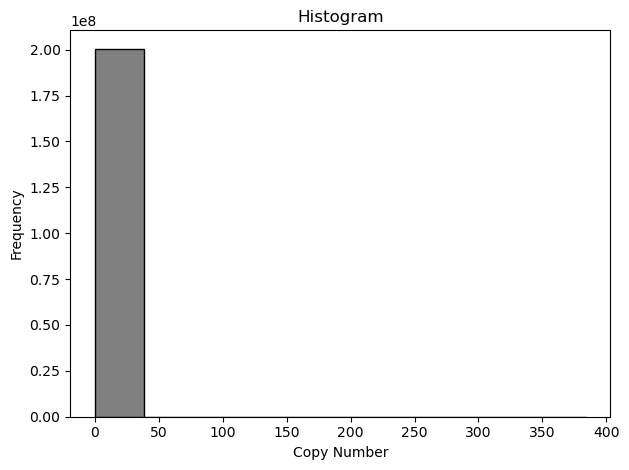

In [10]:
# Histogram of CN values
plt.hist(merged_df['copy_number'], color='gray', edgecolor='black')
plt.title('Histogram')
plt.xlabel('Copy Number')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

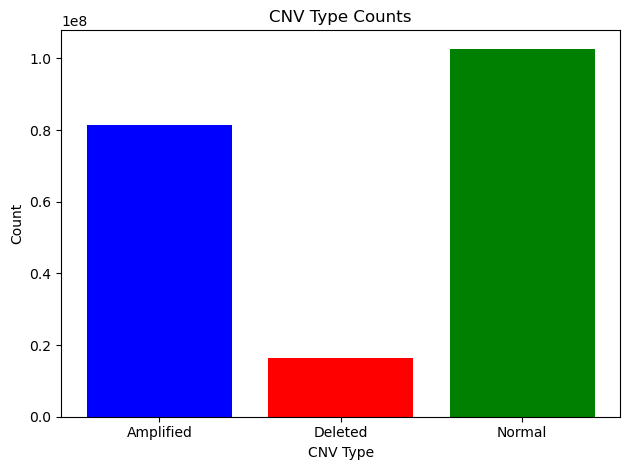

In [11]:
# CNV type counts
cnv_types = merged_df['CNV_Type'].value_counts().sort_index()
plt.bar(cnv_types.index, cnv_types.values, color=['blue', 'red', 'green'])
plt.title('CNV Type Counts')
plt.xlabel('CNV Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [12]:
# cnv_summary_df = pd.DataFrame(all_cnv_counts)

# cnv_summary_df_sorted = cnv_summary_df

# cnv_summary_df_sorted.plot(kind='bar', stacked=True, color=['blue', 'red', 'green'], figsize=(12, 6))
# plt.title('CNV Type Distribution per Sample')
# plt.xlabel('Sample ID')
# plt.ylabel('Count')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

In [13]:
# Concatenate all per-sample gene-wise frequencies
combined_gene_freq = pd.concat(all_gene_freqs, ignore_index=True)

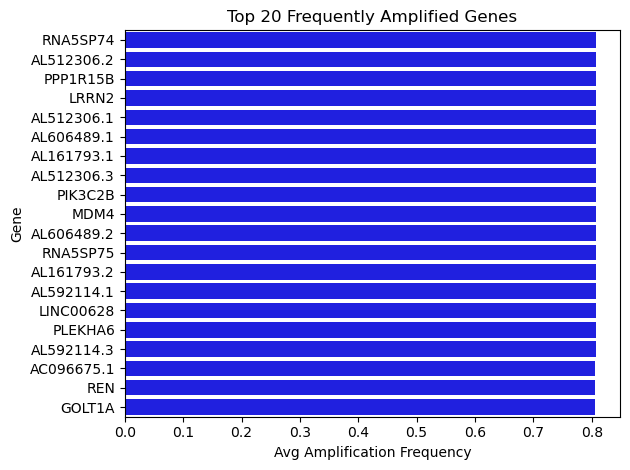

In [14]:
# Top 20 Amplified Genes
top_amplified = combined_gene_freq.groupby('gene_name')['Amplification_Frequency'].mean().sort_values(ascending=False).head(20)
sns.barplot(x=top_amplified.values, y=top_amplified.index, color='blue')
plt.title('Top 20 Frequently Amplified Genes')
plt.xlabel('Avg Amplification Frequency')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

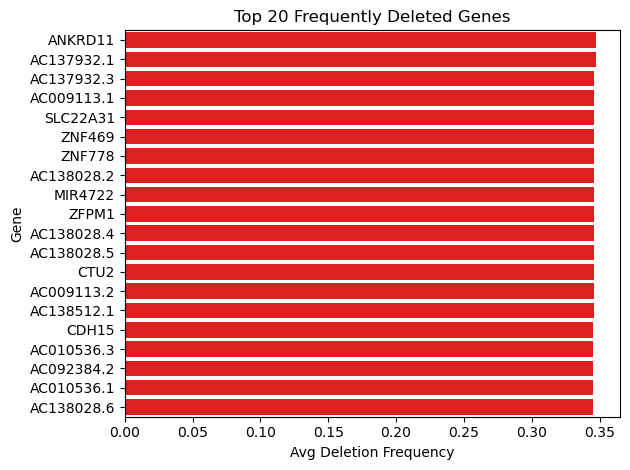

In [15]:
# Top 20 Deleted Genes
top_deleted = combined_gene_freq.groupby('gene_name')['Deletion_Frequency'].mean().sort_values(ascending=False).head(20)
sns.barplot(x=top_deleted.values, y=top_deleted.index, color='red')
plt.title('Top 20 Frequently Deleted Genes')
plt.xlabel('Avg Deletion Frequency')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

In [16]:
# # Count how many times each gene is Amplified or Deleted
# gene_cnv_counts = merged_df[merged_df['CNV_Type'].isin(['Amplified', 'Deleted'])]
# gene_cnv_summary = gene_cnv_counts.groupby(['gene_name', 'CNV_Type']).size().unstack(fill_value=0)

In [17]:
# Gene CNV Summary (Amplified + Deleted only)
# gene_cnv_summary = merged_df[merged_df['CNV_Type'].isin(['Amplified', 'Deleted'])].groupby(['gene_name', 'CNV_Type']).size().unstack(fill_value=0)

from collections import defaultdict

gene_cnv_counts = defaultdict(lambda: {'Amplified': 0, 'Deleted': 0})

# Read each lightweight file one by one
for file in os.listdir(output_dir):
    if not file.endswith("_cnv.csv"):
        continue
    df = pd.read_csv(os.path.join(output_dir, file))
    sub = df[df['CNV_Type'].isin(['Amplified', 'Deleted'])]

    # Count Amplified and Deleted for each gene
    grouped = sub.groupby(['gene_name', 'CNV_Type']).size()
    for (gene, cnv_type), count in grouped.items():
        gene_cnv_counts[gene][cnv_type] += count

# Convert to DataFrame
gene_cnv_summary = pd.DataFrame.from_dict(gene_cnv_counts, orient='index').fillna(0)


top_genes = gene_cnv_summary.sum(axis=1).sort_values(ascending=False).head(20).index
gene_cnv_summary_top = gene_cnv_summary.loc[top_genes]

In [18]:
# # Sort by total CNV activity and pick top 20 genes
# top_genes = gene_cnv_summary.sum(axis=1).sort_values(ascending=False).head(20).index
# gene_cnv_summary_top = gene_cnv_summary.loc[top_genes]

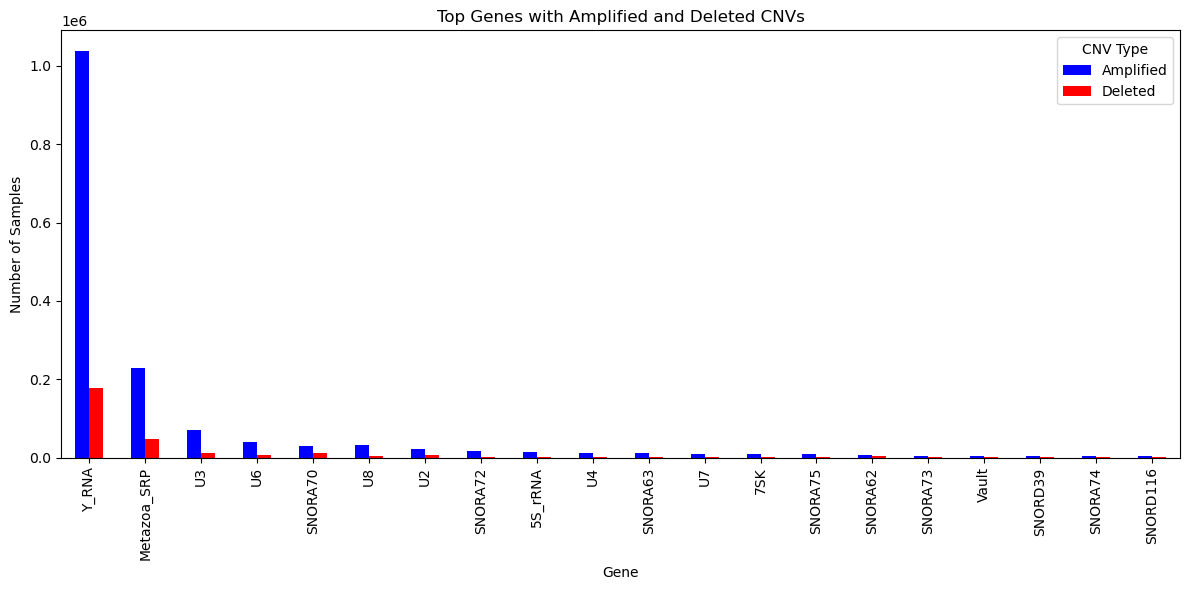

In [20]:
# Grouped bar chart
gene_cnv_summary_top.plot(kind='bar', figsize=(12, 6), color={'Amplified': 'blue', 'Deleted': 'red'})
plt.title('Top Genes with Amplified and Deleted CNVs')
plt.xlabel('Gene')
plt.ylabel('Number of Samples')
plt.legend(title='CNV Type')
plt.tight_layout()
plt.show()

In [155]:
df['CNV_Magnitude'].unique()

array([0., 3., 2., 4., 5., 1.])